# WAV to spectogram converter

### Cell 1 - Imports

In [1]:
import os
import librosa
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

### Cell 2 - Grab the file paths for all the music files

In [2]:
DATASET_PATH = "Data/genres_original"
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
file_paths = []
genre_count = []

# Iterate through each genre and load the audio files
for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                try:
                    # Add file path to the list
                    file_paths.append(file_path)
                    # Assign label based on genre index
                    genre_count.append(genres.index(genre))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

# Print the number of loaded files and labels
print("Files loaded:", len(file_paths))
print("Labels loaded:", len(genre_count))
print("Genres loaded:", len(genres))

genre_count[400], file_paths[400]

Files loaded: 1000
Labels loaded: 1000
Genres loaded: 10


(4, 'Data/genres_original/hiphop/hiphop.00022.wav')

### Cell 3 - Show an example of a spectogram on the console

In [ ]:
%matplotlib inline


# Load the audio
y, sr = librosa.load(file_paths[2], sr=22050)

# Generate the STFT (Short-Time Fourier Transform) for a normal spectrogram
D = np.abs(librosa.stft(y, n_fft=1024, hop_length=1024))  # Recommended values
D_db = librosa.amplitude_to_db(D, ref=np.max)

# Create the plot
plt.figure(figsize=(5, 5))
plt.gca().set_axis_off()  # Remove axes
plt.gca().set_facecolor('none')  # Transparent background
librosa.display.specshow(D_db, sr=sr, hop_length=1024, x_axis='time', y_axis='mel', fmax=8000)

# Save for CNN input
# plt.savefig("spectrogram_image.png", bbox_inches='tight', pad_inches=0, transparent=True, dpi=300)

# Display the plot
plt.show()

print(file_paths[4])

### Cell 4 - Create the folders to put the code into and create all spectograms for each .wav file across three separate n_mel values

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

def create_spectogram(genre, file_path, hop_length):
    
    # Load the audio
    y, sr = librosa.load(file_path, sr=22050)

    # Generate the STFT (Short-Time Fourier Transform) for a normal spectrogram
    D = np.abs(librosa.stft(y, n_fft=1024, hop_length=hop_length))  # Recommended values
    D_db = librosa.amplitude_to_db(D, ref=np.max)

    # Create the plot
    plt.figure(figsize=(5, 5))
    plt.gca().set_axis_off()  # Remove axes
    plt.gca().set_facecolor('none')  # Transparent background
    librosa.display.specshow(D_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmax=8000)
    
    # Create the path for saving the image
    savingFilePath = os.path.join("Data", "spectrograms", "spectrogram_" + str(hop_length), genre, os.path.basename(file_path[:-4]) + ".png")
    
    # Create any missing directories
    os.makedirs(os.path.dirname(savingFilePath), exist_ok=True)
        
    # Save the image
    plt.savefig(savingFilePath, bbox_inches='tight', pad_inches=0, transparent=True, dpi=300)
    plt.clf()
    plt.close()

    if i % 50 == 0:
        gc.collect()

# Create parent directory
path = os.path.join("Data", "spectrograms")
os.makedirs(path, exist_ok=True)
        
hop_lengths = [256, 512]

for hop_length in hop_lengths:
    folder_path = os.path.join("Data", "spectrograms", "spectrogram_" + str(hop_length))
    os.makedirs(folder_path, exist_ok=True)
    for genre in genres:
        folder_path = os.path.join("Data", "spectrograms", "spectrogram_" + str(hop_length), genre)
        os.makedirs(folder_path, exist_ok=True)

for hop_length in hop_lengths:
    for i in range(len(file_paths)):  # Iterate over all file paths
        genre = genres[genre_count[i]]  # Ensure the genre matches the index
        file_path = file_paths[i]  # Get the corresponding file path    
        create_spectogram(genre, file_path, hop_length)

# 5 - The same again, but for 3-second clips

Processing spectrograms for Data/genres_original/blues/blues.00093.wav


/Users/conorwoollatt/.pyenv/versions/3.9.6/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=0
  warnings.warn(


Processing spectrograms for Data/genres_original/blues/blues.00087.wav
Processing spectrograms for Data/genres_original/blues/blues.00050.wav
Processing spectrograms for Data/genres_original/blues/blues.00044.wav
Processing spectrograms for Data/genres_original/blues/blues.00078.wav
Processing spectrograms for Data/genres_original/blues/blues.00079.wav
Processing spectrograms for Data/genres_original/blues/blues.00045.wav
Processing spectrograms for Data/genres_original/blues/blues.00051.wav
Processing spectrograms for Data/genres_original/blues/blues.00086.wav
Processing spectrograms for Data/genres_original/blues/blues.00092.wav
Processing spectrograms for Data/genres_original/blues/blues.00084.wav
Processing spectrograms for Data/genres_original/blues/blues.00090.wav
Processing spectrograms for Data/genres_original/blues/blues.00047.wav
Processing spectrograms for Data/genres_original/blues/blues.00053.wav
Processing spectrograms for Data/genres_original/blues/blues.00052.wav
Proces

KeyboardInterrupt: 

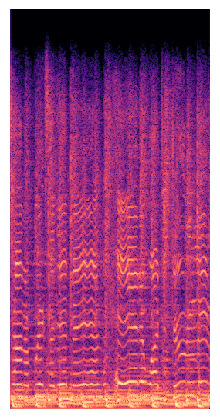

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import gc

def create_spectrogram_clip(genre, file_path, hop_length, clip_number, total_clips=10):
    # Load the audio
    y, sr = librosa.load(file_path, sr=22050)
    
    # Calculate the start and end time for the clip
    start_time = (clip_number - 1) * 3  # 3-second intervals (clip_number is 1-based)
    end_time = clip_number * 3  # 3-second intervals
    
    # Slice the audio to the desired time segment (start_time to end_time)
    y_segment = y[int(start_time * sr): int(end_time * sr)]
    
    # Generate the STFT (Short-Time Fourier Transform) for a normal spectrogram
    D = np.abs(librosa.stft(y_segment, n_fft=1024, hop_length=hop_length))
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    
    # Create a figure with tight layout and no extra space
    plt.figure(figsize=(2, 4), frameon=False)
    
    # Create the subplot with no padding
    ax = plt.subplot(111)
    
    # Plot the spectrogram
    librosa.display.specshow(D_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', fmax=8000, ax=ax)
    
    # Remove axes, ticks, and labels
    ax.set_axis_off()
    
    # Set the background to transparent
    ax.set_facecolor('none')
    
    # Remove all margins and padding
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    
    # Prepare the saving path
    savingFilePath = os.path.join("Data", "spectrograms (3 secs)", f"spectrogram_{str(hop_length)}",
                              genre, os.path.basename(file_path[:-4]) + f".{clip_number}.png")
    
    # Create any missing directories
    os.makedirs(os.path.dirname(savingFilePath), exist_ok=True)
    
    # Save with tight bounding box and explicitly set zero padding
    plt.savefig(savingFilePath, bbox_inches='tight', pad_inches=0, transparent=True, dpi=300, format='png')
    
    # Clean up
    plt.clf()
    plt.close('all')  # Close all figures to prevent memory leaks
    
    # Optionally, collect garbage to manage memory usage
    if clip_number % 50 == 0:
        gc.collect()

# Create the parent directory for the spectrograms (3 secs)
os.makedirs(os.path.join("Data", "spectrograms (3 secs)"), exist_ok=True)

# Different values for hop_length
hop_lengths = [256, 512]

# Create the folders for saving the spectrograms
for hop_length in hop_lengths:
    os.makedirs(os.path.join("Data", "spectrograms (3 secs)", f"spectrogram_{str(hop_length)}"), exist_ok=True)
    for genre in genres:
        os.makedirs(os.path.join("Data", "spectrograms (3 secs)", f"spectrogram_{str(hop_length)}", genre), exist_ok=True)

# Iterate through each song, generating 10 clips per song
for hop_length in hop_lengths:
    for i in range(len(file_paths)):  # Iterate over all file paths
        genre = genres[genre_count[i]]  # Ensure the genre matches the index
        file_path = file_paths[i]  # Get the corresponding file path
        print(f"Processing spectrograms for {file_path}")
        
        # Generate 10 segments for each song (each 3 seconds)
        for clip_number in range(0, 10):  # From clip 1 to 10
            # print(f"Processing clip {clip_number} of 10 for {file_path}")
            create_spectrogram_clip(genre, file_path, hop_length, clip_number)